In [2]:
import argparse
import pandas as pd
import numpy as np
import os
import sys  
sys.path.insert(0, './../MAIN/')
from utils import *
from GNN_MME import *
from train import *
import preprocess_functions

import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold , train_test_split
import networkx as nx
import torch
from datetime import datetime
import joblib
import warnings
import gc
warnings.filterwarnings("ignore")

print("Finished Library Import \n")

Finished Library Import 



In [1]:
data_input = './../../data/TCGA/BRCA/raw/'
snf_net = 'RPPA_mRNA_graph.graphml'
index_col = 'index'
target = 'paper_BRCA_Subtype_PAM50'

Using cuda device
Total = 11.5Gb 	 Reserved = 0.0Gb 	 Allocated = 0.0Gb
StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
GCN_MME(
  (encoder_dims): ModuleList(
    (0): Encoder(
      (encoder): ModuleList(
        (0): Linear(in_features=464, out_features=500, bias=True)
        (1): Linear(in_features=500, out_features=16, bias=True)
      )
      (norm): ModuleList(
        (0): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (decoder): Sequential(
        (0): Linear(in_features=16, out_features=64, bias=True)
      )
      (drop): Dropout(p=0.5, inplace=False)
    )
    (1): Encoder(
      (encoder): ModuleList(
        (0): Linear(in_features=29995, out_features=500, bias=True)
        (1): Linear(in_features=500, out_features=16, bias=True)
      )
      (norm): ModuleList(
        (0): BatchNorm1d(500, eps=1e-05, momentum=0.1, a

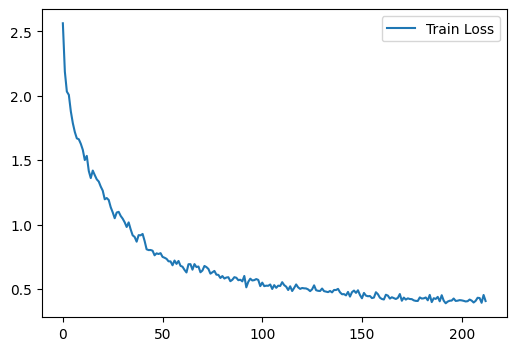

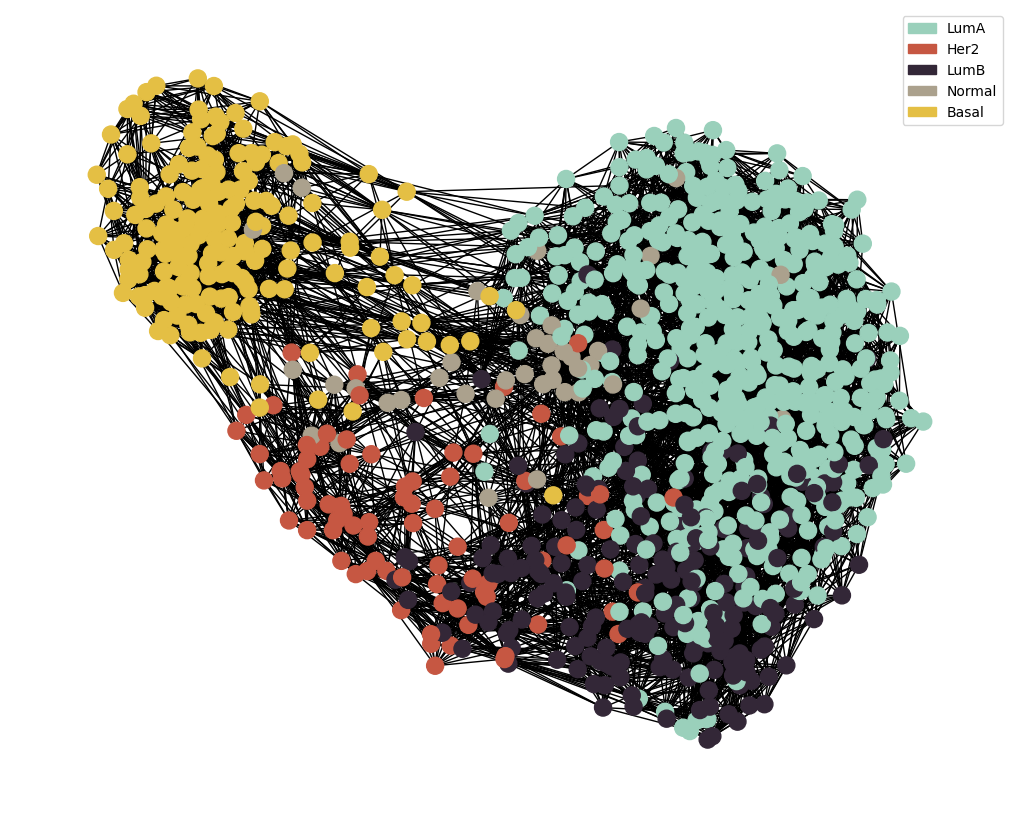

Pretraining | Loss = 0.5510 | Accuracy = 0.8102 
Graph(num_nodes=1076, num_edges=18228,
      ndata_schemes={'idx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(5,), dtype=torch.int64), 'feat': Scheme(shape=(30459,), dtype=torch.float32)}
      edata_schemes={})
Epoch 00000 | Loss 1.7739 | Train Acc. 0.2407 | 
Epoch 00005 | Loss 0.6968 | Train Acc. 0.7733 | 
Epoch 00010 | Loss 0.5570 | Train Acc. 0.8326 | 
Epoch 00015 | Loss 0.4759 | Train Acc. 0.8512 | 
Epoch 00020 | Loss 0.4686 | Train Acc. 0.8453 | 
Epoch 00025 | Loss 0.4224 | Train Acc. 0.8616 | 
Epoch 00030 | Loss 0.4072 | Train Acc. 0.8721 | 
Epoch 00035 | Loss 0.3894 | Train Acc. 0.8663 | 
Epoch 00040 | Loss 0.3634 | Train Acc. 0.8791 | 
Epoch 00045 | Loss 0.3607 | Train Acc. 0.8721 | 
Epoch 00050 | Loss 0.3470 | Train Acc. 0.8686 | 
Epoch 00055 | Loss 0.3503 | Train Acc. 0.8686 | 
Epoch 00060 | Loss 0.3389 | Train Acc. 0.8791 | 
Epoch 00065 | Loss 0.3306 | Train Acc. 0.8884 | 
Epoch 00070 | Loss 0.3367 | Train Ac

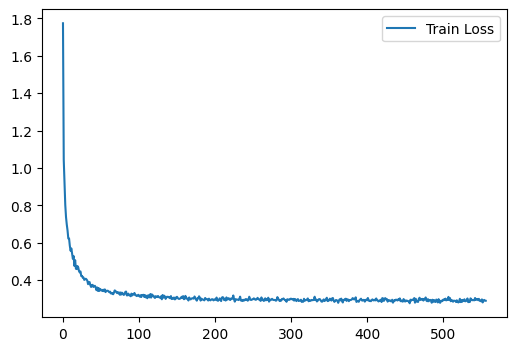

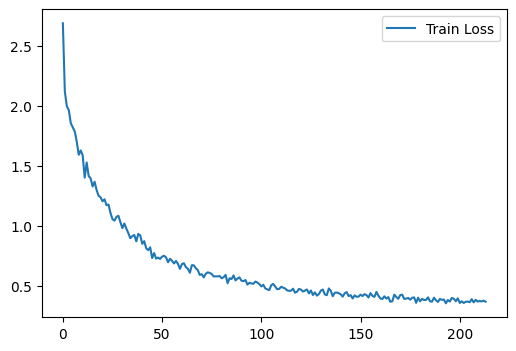

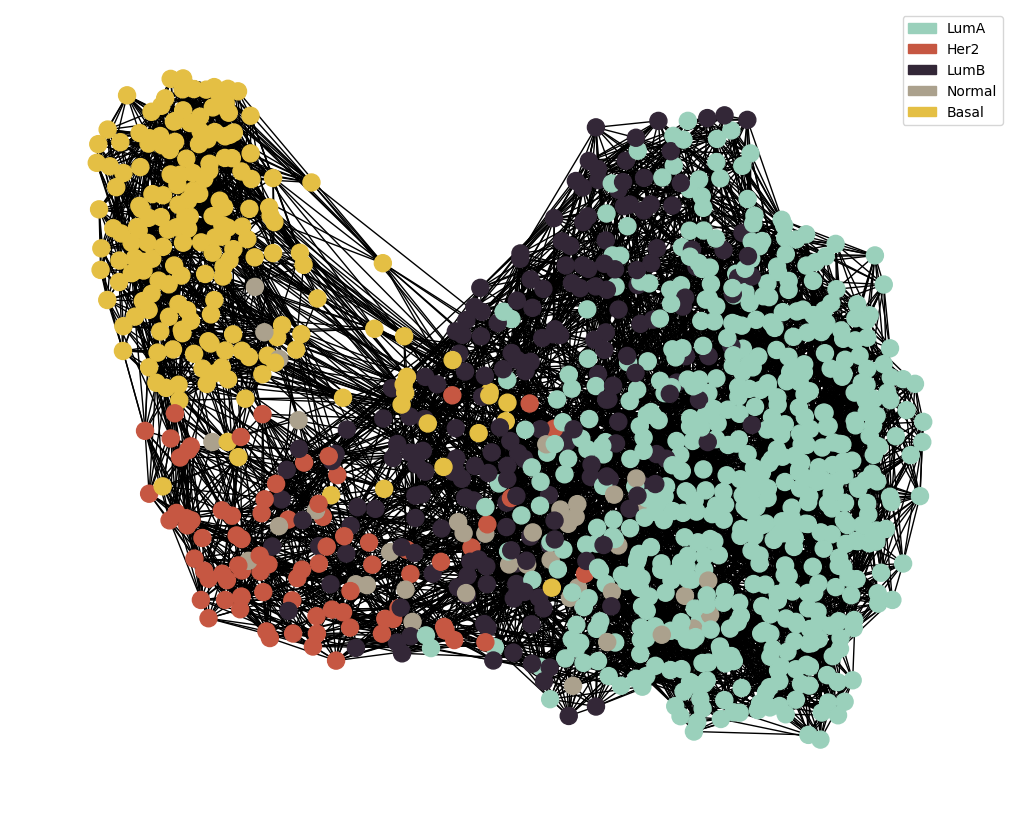

Pretraining | Loss = 0.4685 | Accuracy = 0.8279 
Graph(num_nodes=1076, num_edges=18258,
      ndata_schemes={'idx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(5,), dtype=torch.int64), 'feat': Scheme(shape=(30459,), dtype=torch.float32)}
      edata_schemes={})
Epoch 00000 | Loss 1.9014 | Train Acc. 0.1638 | 
Epoch 00005 | Loss 0.7603 | Train Acc. 0.7747 | 
Epoch 00010 | Loss 0.6843 | Train Acc. 0.7898 | 
Epoch 00015 | Loss 0.5992 | Train Acc. 0.8397 | 
Epoch 00020 | Loss 0.5426 | Train Acc. 0.8397 | 
Epoch 00025 | Loss 0.5059 | Train Acc. 0.8479 | 
Epoch 00030 | Loss 0.4835 | Train Acc. 0.8548 | 
Epoch 00035 | Loss 0.4250 | Train Acc. 0.8688 | 
Epoch 00040 | Loss 0.4139 | Train Acc. 0.8699 | 
Epoch 00045 | Loss 0.3971 | Train Acc. 0.8664 | 
Epoch 00050 | Loss 0.3936 | Train Acc. 0.8734 | 
Epoch 00055 | Loss 0.3823 | Train Acc. 0.8664 | 
Epoch 00060 | Loss 0.3937 | Train Acc. 0.8641 | 
Epoch 00065 | Loss 0.4018 | Train Acc. 0.8618 | 
Epoch 00070 | Loss 0.3935 | Train Ac

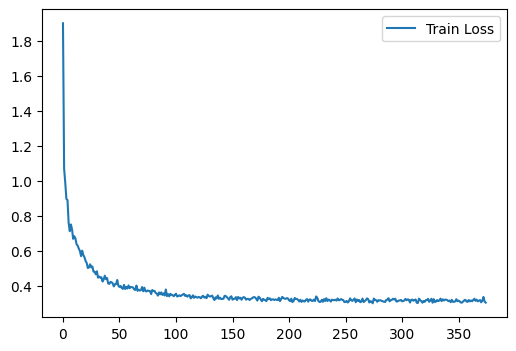

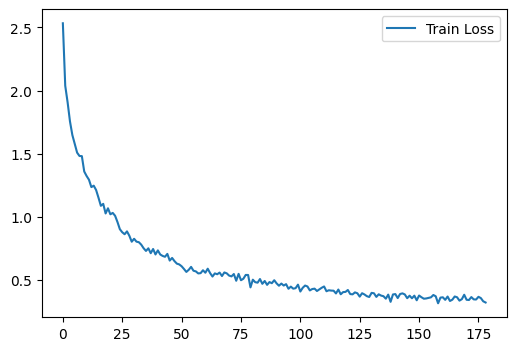

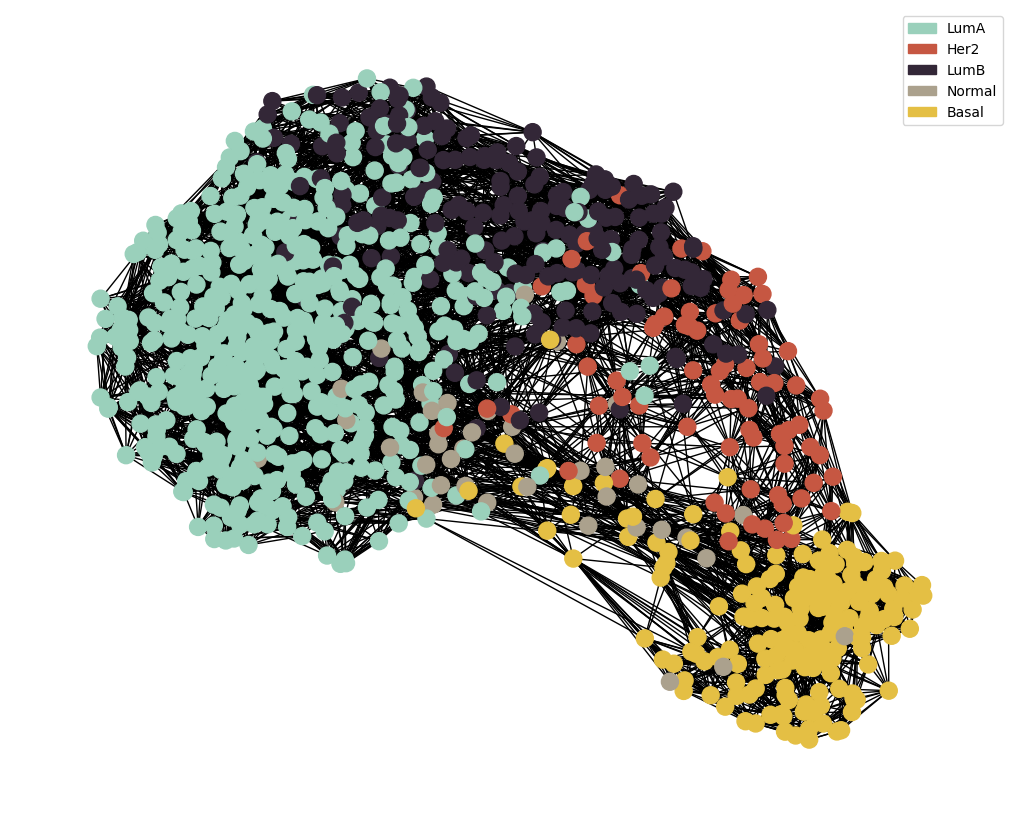

Pretraining | Loss = 0.6757 | Accuracy = 0.7814 
Graph(num_nodes=1076, num_edges=18184,
      ndata_schemes={'idx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(5,), dtype=torch.int64), 'feat': Scheme(shape=(30459,), dtype=torch.float32)}
      edata_schemes={})
Epoch 00000 | Loss 2.2924 | Train Acc. 0.0871 | 
Epoch 00005 | Loss 0.5731 | Train Acc. 0.8339 | 
Epoch 00010 | Loss 0.4972 | Train Acc. 0.8537 | 
Epoch 00015 | Loss 0.4760 | Train Acc. 0.8374 | 
Epoch 00020 | Loss 0.4358 | Train Acc. 0.8548 | 
Epoch 00025 | Loss 0.4170 | Train Acc. 0.8548 | 
Epoch 00030 | Loss 0.3926 | Train Acc. 0.8792 | 
Epoch 00035 | Loss 0.3897 | Train Acc. 0.8618 | 
Epoch 00040 | Loss 0.3732 | Train Acc. 0.8641 | 
Epoch 00045 | Loss 0.3575 | Train Acc. 0.8769 | 
Epoch 00050 | Loss 0.3568 | Train Acc. 0.8711 | 
Epoch 00055 | Loss 0.3748 | Train Acc. 0.8746 | 
Epoch 00060 | Loss 0.3599 | Train Acc. 0.8699 | 
Epoch 00065 | Loss 0.3537 | Train Acc. 0.8711 | 
Epoch 00070 | Loss 0.3498 | Train Ac

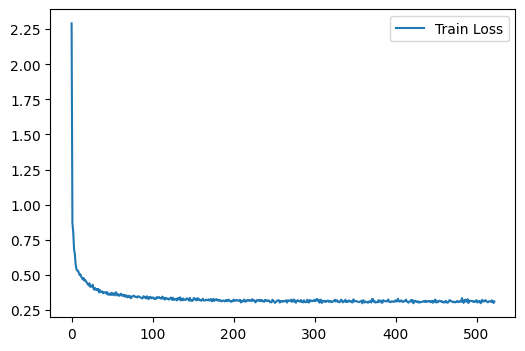

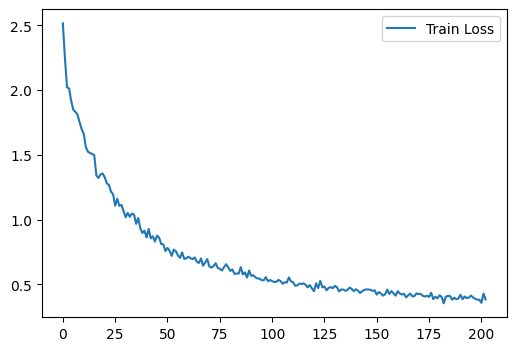

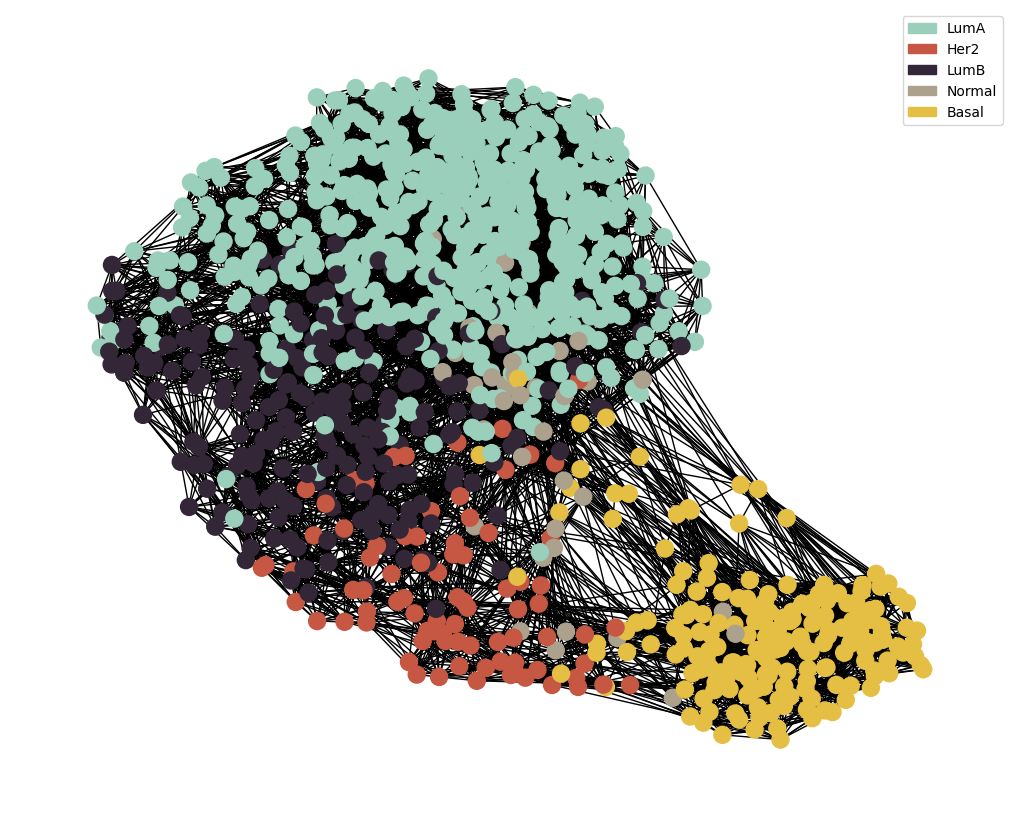

Pretraining | Loss = 0.5223 | Accuracy = 0.7953 
Graph(num_nodes=1076, num_edges=18124,
      ndata_schemes={'idx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(5,), dtype=torch.int64), 'feat': Scheme(shape=(30459,), dtype=torch.float32)}
      edata_schemes={})
Epoch 00000 | Loss 1.8310 | Train Acc. 0.1858 | 
Epoch 00005 | Loss 0.6421 | Train Acc. 0.8037 | 
Epoch 00010 | Loss 0.5804 | Train Acc. 0.8118 | 
Epoch 00015 | Loss 0.4663 | Train Acc. 0.8606 | 
Epoch 00020 | Loss 0.4653 | Train Acc. 0.8688 | 
Epoch 00025 | Loss 0.4283 | Train Acc. 0.8571 | 
Epoch 00030 | Loss 0.3831 | Train Acc. 0.8746 | 
Epoch 00035 | Loss 0.3809 | Train Acc. 0.8769 | 
Epoch 00040 | Loss 0.3883 | Train Acc. 0.8711 | 
Epoch 00045 | Loss 0.3778 | Train Acc. 0.8746 | 
Epoch 00050 | Loss 0.3672 | Train Acc. 0.8734 | 
Epoch 00055 | Loss 0.3683 | Train Acc. 0.8734 | 
Epoch 00060 | Loss 0.3626 | Train Acc. 0.8734 | 
Epoch 00065 | Loss 0.3699 | Train Acc. 0.8688 | 
Epoch 00070 | Loss 0.3566 | Train Ac

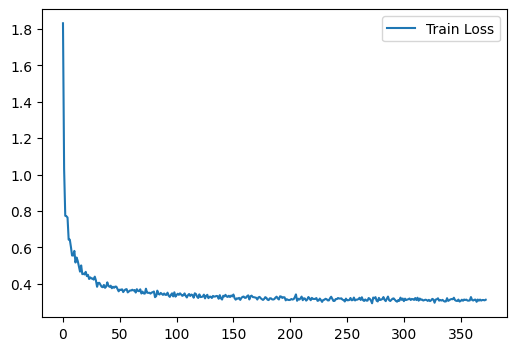

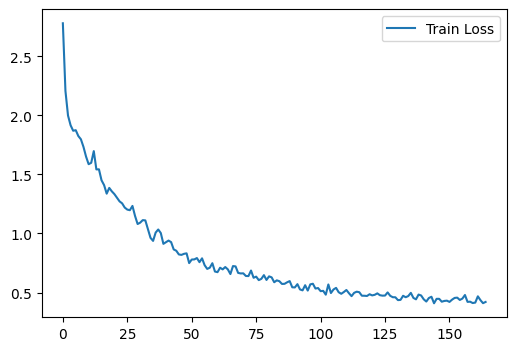

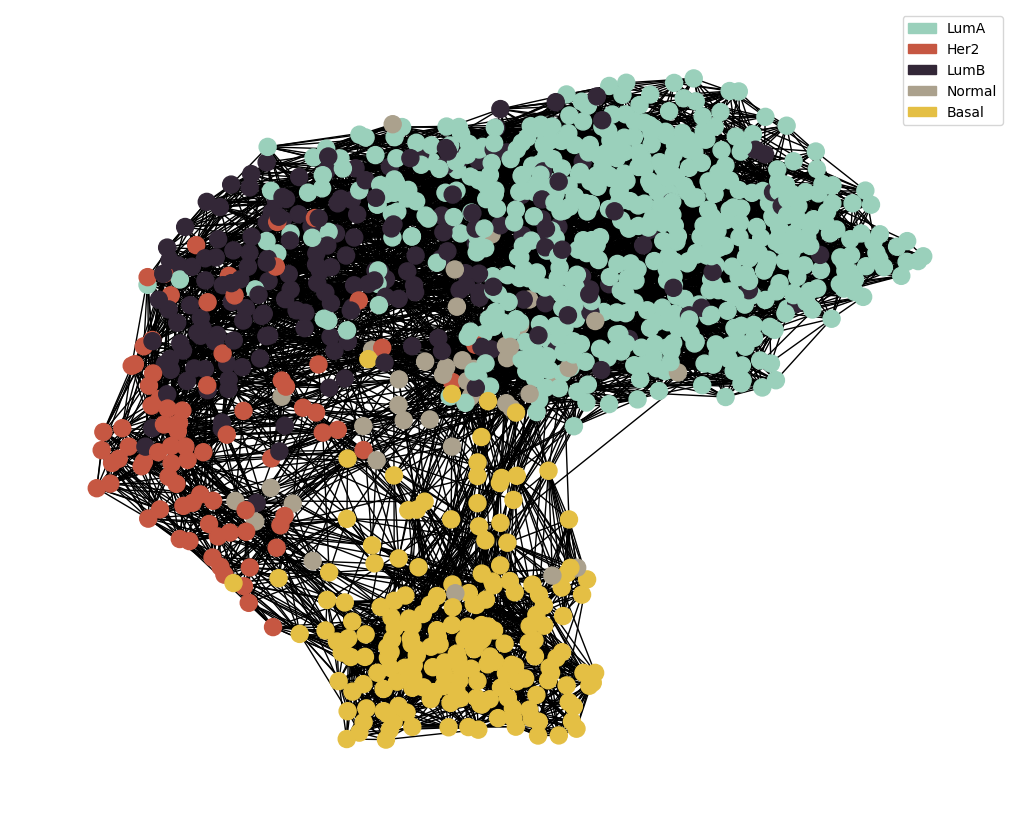

Pretraining | Loss = 0.5026 | Accuracy = 0.8419 
Graph(num_nodes=1076, num_edges=18162,
      ndata_schemes={'idx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(5,), dtype=torch.int64), 'feat': Scheme(shape=(30459,), dtype=torch.float32)}
      edata_schemes={})
Epoch 00000 | Loss 1.6768 | Train Acc. 0.2242 | 
Epoch 00005 | Loss 0.8516 | Train Acc. 0.7189 | 
Epoch 00010 | Loss 0.6726 | Train Acc. 0.8084 | 
Epoch 00015 | Loss 0.5935 | Train Acc. 0.8293 | 
Epoch 00020 | Loss 0.5480 | Train Acc. 0.8339 | 
Epoch 00025 | Loss 0.5067 | Train Acc. 0.8386 | 
Epoch 00030 | Loss 0.4772 | Train Acc. 0.8571 | 
Epoch 00035 | Loss 0.4253 | Train Acc. 0.8757 | 
Epoch 00040 | Loss 0.4283 | Train Acc. 0.8595 | 
Epoch 00045 | Loss 0.4245 | Train Acc. 0.8618 | 
Epoch 00050 | Loss 0.4036 | Train Acc. 0.8711 | 
Epoch 00055 | Loss 0.3948 | Train Acc. 0.8664 | 
Epoch 00060 | Loss 0.3862 | Train Acc. 0.8664 | 
Epoch 00065 | Loss 0.3899 | Train Acc. 0.8734 | 
Epoch 00070 | Loss 0.3865 | Train Ac

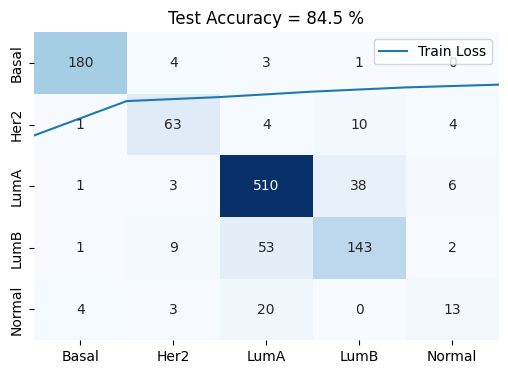

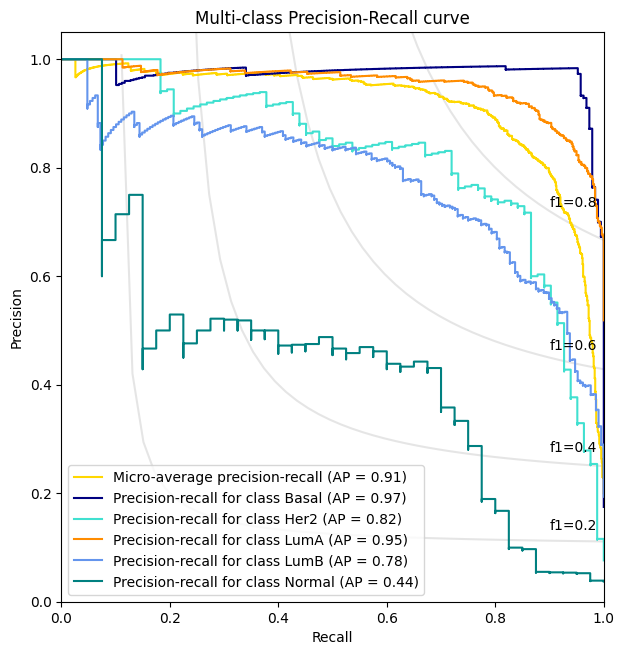

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')# Get GPU device name, else use CPU
print("Using %s device" % device)
get_gpu_memory()

datModalities , meta = data_parsing(data_input , ['RPPA', 'mRNA'] , target , index_col)

graph_file = data_input + '../Networks/' + snf_net
g = nx.read_graphml(graph_file)

meta = meta.loc[sorted(meta.index)]
label = F.one_hot(torch.Tensor(list(meta.astype('category').cat.codes)).to(torch.int64))

skf = StratifiedKFold(n_splits=5 , shuffle=True) 

print(skf)

MME_input_shapes = [datModalities[mod].shape[1] for mod in datModalities]

h = reduce(merge_dfs , list(datModalities.values()))
h = h.loc[sorted(h.index)]

del datModalities
gc.collect()

output_metrics = []
test_logits = []
test_labels = []

for i, (train_index, test_index) in enumerate(skf.split(meta.index, meta)) :
    
    model = GCN_MME(MME_input_shapes , [16 , 16] , 64 , [32]  , len(meta.unique())).to(device)
    g = dgl.graph(([], []) , num_nodes=len(meta))
    g = dgl.add_self_loop(g)
    g.ndata['feat'] = torch.Tensor(h.to_numpy())
    g.ndata['label'] = label
    g = g.to(device)
    
    print(model)
    print(g)

    G = train(g, train_index, device ,  model , meta , 500 , 1e-3 , 20, pretrain=True)
    
    sampler = NeighborSampler(
        [15 for i in range(len(model.gnnlayers))],  # fanout for each layer
        prefetch_node_feats=['feat'],
        prefetch_labels=['label'],
    )
    test_dataloader = DataLoader(
        g,
        torch.Tensor(test_index).to(torch.int64).to(device),
        sampler,
        device=device,
        batch_size=1024,
        shuffle=True,
        drop_last=False,
        num_workers=0,
        use_uva=False,
    )
    
    test_output_metrics = evaluate(model , g, test_dataloader)
    
    print(
        "Pretraining | Loss = {:.4f} | Accuracy = {:.4f} ".format(
         test_output_metrics[0] , test_output_metrics[1] )
    )
    
    with torch.no_grad():
        torch.cuda.empty_cache()
    gc.collect()

    model = model.apply(init_weights)

    g = dgl.from_networkx(G , node_attrs=['idx' , 'label'])
    g.ndata['feat'] = torch.Tensor(h.to_numpy())
    g.ndata['label'] = label
    g = g.to(device)
    
    print(g)
    
    loss_plot = train(g, train_index, device ,  model , meta , 2000 , 1e-3 , 100)
    
    sampler = NeighborSampler(
        [15 for i in range(len(model.gnnlayers))],  # fanout for each layer
        prefetch_node_feats=['feat'],
        prefetch_labels=['label'],
    )
    test_dataloader = DataLoader(
        g,
        torch.Tensor(test_index).to(torch.int64).to(device),
        sampler,
        device=device,
        batch_size=1024,
        shuffle=True,
        drop_last=False,
        num_workers=0,
        use_uva=False,
    )
    
    test_output_metrics = evaluate(model , g, test_dataloader)

    print(
        "Fold : {:01d} | Test Accuracy = {:.4f} | F1 = {:.4f} ".format(
        i+1 , test_output_metrics[1] , test_output_metrics[2] )
    )
    
    test_logits.extend(test_output_metrics[-2])
    test_labels.extend(test_output_metrics[-1])
    
    output_metrics.append(test_output_metrics)
    if i == 0 : 
        best_model = model
        best_idx = i
    elif output_metrics[best_idx][1] < test_output_metrics[1] : 
        best_model = model
        best_idx   = i

    get_gpu_memory()
    del model
    gc.collect()
    torch.cuda.empty_cache()
    print('Clearing gpu memory')
    get_gpu_memory()

test_logits = torch.stack(test_logits)
test_labels = torch.stack(test_labels)

accuracy = []
F1 = []
i = 0
for metric in output_metrics :
    
    accuracy.append(metric[1])
    F1.append(metric[2])


print("%i Fold Cross Validation Accuracy = %2.2f \u00B1 %2.2f" %(5 , np.mean(accuracy)*100 , np.std(accuracy)*100))
print("%i Fold Cross Validation F1 = %2.2f \u00B1 %2.2f" %(5 , np.mean(F1)*100 , np.std(F1)*100))

confusion_matrix(test_logits , test_labels , meta.astype('category').cat.categories)
plt.title('Test Accuracy = %2.1f %%' % (np.mean(accuracy)*100))

precision_recall_plot , all_predictions_conf = AUROC(test_logits, test_labels , meta)

node_predictions = []
node_true        = []
display_label = meta.astype('category').cat.categories
for pred , true in zip(all_predictions_conf.argmax(1) , list(test_labels.detach().cpu().argmax(1).numpy()))  : 
    node_predictions.append(display_label[pred])
    node_true.append(display_label[true])

tst = pd.DataFrame({'Actual' : node_true , 'Predicted' : node_predictions})